In [1]:
import os
import sys 
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
sess = tf.Session()
%matplotlib inline

In [2]:
#Now we will declare some of the model parameters. Our batch size will be 128 (for train and test). We will output a 
#status every 50 generations and run for a total of 20,000 generations. Every 500 generations, we will evaluate on a batch
#of the test data. We will then declare some image parameters, height and width, and what size the random cropped images
#will take. There are three channels (red, green, and blue) and we have ten different targets. Then we will declare where
#we will store the data and image batches from the queue
batch_size = 128
data_dir = 'temp'
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

In [3]:
#It is recommended to lower the learning rate as we progress towards a good model, so we will exponentially decrease the
#learning rate: the initial learning rate will be set at 0.1, and we will exponentially decrease it by a factor of 10% 
#every 250 generations. The default is for this to continually decrease, but TensorFlow does accept a staircase argument
#which only updates the learning rate
learning_rate = 0.1
lr_decay = 0.9
num_gens_to_wait = 250.

In [4]:
#Now we will set up parameters so that we can read in the binary CIFAR-10 images
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length

In [6]:
#Next, we will set up the data directory and the URL to download the CIFAR-10 images, if we dont have them already
data_dir = 'temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

# Check if file exists, otherwise download it
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [7]:
#We will set up the record reader and return a randomly distorted image with the following read_cifar_files() function.
#First, we need to declare a record reader object that will read in a fixed length of bytes. After we read the image
#queue, we will split apart the image and label. Finally, we will randomly distort the image with TensorFlow's built in
#image modification functions. 
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
  
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]),
                                 [num_channels, image_height, image_width])
    
    # Reshape image
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    
    if distort_images:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        final_image = tf.image.random_contrast(final_image,lower=0.2, upper=1.8)

    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image)
    return(final_image, image_label)

In [8]:
#Now we will declare a function that will populate our image pipeline for the batch processor to use. We first need to set
#up the file list of images we want to read through prebuilt TensorFlow functions. The input produces can be passed into 
#the reading function that we created in the preceding step, read_cifar_files(). We will then set a batch reader on the 
#queue, shuffle_batch().
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    # min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    # capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image, label],
                                                        batch_size=batch_size,
                                                        capacity=capacity,
                                                        min_after_dequeue=min_after_dequeue)

    return(example_batch, label_batch)

In [9]:
#Next, we can declare our model function. The model we will use has two convolutional layers, followed by three fully 
#connected layers. To make variable declaration easier, we will start by declaring two variable functions. The two 
#convolutional layers, will create 64 features each. The first fully connected layer will connect the 2nd convolutional
#layer with 384 hidden nodes. The second fully connected operation will connect those 384 hidden nodes to 192 hidden 
#nodes. The final hidden layer operation will the  connect the 192 nodes to the 10 output classes we are trying to
#predict.
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    def truncated_normal_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.truncated_normal_initializer(stddev=0.05)))
    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        # Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name='conv_kernel1', shape=[5, 5, 3, 64], dtype=tf.float32)
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias term
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        # ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool_layer1')
    
    # Local Response Normalization (parameters from paper)
    # paper: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')

    # Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 64], dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    
    # Max Pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')    
    
     # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    # Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    # First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))

    # Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))

    # Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope('full3') as scope:
        # Final fully connected layer has 10 (num_targets) outputs.
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 =  zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return(final_output)

In [10]:
#Now we will create the loss function. We will use the softmax function because a picture can only take on exactly one
#category, so the output should be a probability distribution over the ten targets
def cifar_loss(logits, targets):
    # Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    # Take the average loss across batch size
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return(cross_entropy_mean)

In [11]:
#Next, we declare our training step. The learning rate will decrease in an exponential step function. 
def train_step(loss_value, generation_num):
    #Our learning rate is an exponential decay (stepped down)
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num, num_gens_to_wait,
                                                    lr_decay, staircase=True)
    #Create optimizer 
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    #Initialize train step
    train_step = my_optimizer.minimize(loss_value)
    return(train_step)

In [12]:
#We must also have an accuracy funtion that calculates the accuracy across a batch of images. We will input the logits and
#target vectors, and output an averaged accuracy. We can then use this for both the train and test batches
def accuracy_of_batch(logits, targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions, targets)
    # Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return(accuracy)

In [13]:
#Now that we have an imagepipeline function, we can initialize both the training image pipeline and the test image
#pipeline
images, targets = input_pipeline(batch_size, train_logical=True)
test_images, test_targets = input_pipeline(batch_size, train_logical=False)

In [14]:
#Next, we will initialize our loss and test accuracy functions. Then we will declare the generation variable. This 
#variable needs to be declares as non-trainable, and passed to our training function that uses it in the learning rate 
#exponential decay calculation 
with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images, batch_size)
    # This is very important!!!  We must set the scope to REUSE the variables,
    #  otherwise, when we set the test network model, it will create new random
    #  variables.  Otherwise we get random evaluations on the test batches.
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)

In [15]:
#We can now initialize our loss and test accuracy functions. Then we will declare the generation variable. This variable
#needs to be declared as non-trainable, and passed to our training function that uses it in the learning rate exponential
#decay calculation
loss = cifar_loss(model_output, targets)
accuracy = accuracy_of_batch(test_output, test_targets)
generation_num = tf.Variable(0,trainable=False)
train_op = train_step(loss, generation_num)

In [16]:
#We will now initialize all of the model's variables and then start the image pipeline by running the TensorFlow function,
#start_queue_runners(). When we start the train or test model output, the pipeline will feed in a batch of images in place
#of a feed dictionary
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 139792192894720)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139792184502016)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 139792176109312)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 139792167716608)>]

In [17]:
#We now loop through our training generations and save the training loss and the test accuracy
print('Starting Training')
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)
    
    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy = {:.2f}%.'.format(100.*temp_accuracy)
print(acc_output)

Starting Training
Generation 50: Loss = 2.07492
Generation 100: Loss = 1.84485
Generation 150: Loss = 1.77737
Generation 200: Loss = 1.72815
Generation 250: Loss = 1.41830
Generation 300: Loss = 1.51660
Generation 350: Loss = 1.63885
Generation 400: Loss = 1.49586
Generation 450: Loss = 1.38226
Generation 500: Loss = 1.47336
Generation 550: Loss = 1.47964
Generation 600: Loss = 1.40792
Generation 650: Loss = 1.40611
Generation 700: Loss = 1.64999
Generation 750: Loss = 1.41991
Generation 800: Loss = 1.21084
Generation 850: Loss = 1.25373
Generation 900: Loss = 1.25681
Generation 950: Loss = 1.17166
Generation 1000: Loss = 1.12144
Generation 1050: Loss = 1.35681
Generation 1100: Loss = 1.24420
Generation 1150: Loss = 1.23665
Generation 1200: Loss = 1.14743
Generation 1250: Loss = 1.16401
Generation 1300: Loss = 1.07522
Generation 1350: Loss = 1.24182
Generation 1400: Loss = 1.07513
Generation 1450: Loss = 1.00016
Generation 1500: Loss = 0.97438
Generation 1550: Loss = 1.01082
Generation

Generation 12800: Loss = 0.10301
Generation 12850: Loss = 0.33953
Generation 12900: Loss = 0.12236
Generation 12950: Loss = 0.22891
Generation 13000: Loss = 0.11730
Generation 13050: Loss = 0.14962
Generation 13100: Loss = 0.09144
Generation 13150: Loss = 0.15769
Generation 13200: Loss = 0.10828
Generation 13250: Loss = 0.20293
Generation 13300: Loss = 0.11137
Generation 13350: Loss = 0.09014
Generation 13400: Loss = 0.09527
Generation 13450: Loss = 0.19925
Generation 13500: Loss = 0.17610
Generation 13550: Loss = 0.21529
Generation 13600: Loss = 0.06518
Generation 13650: Loss = 0.07295
Generation 13700: Loss = 0.09388
Generation 13750: Loss = 0.10840
Generation 13800: Loss = 0.14798
Generation 13850: Loss = 0.08812
Generation 13900: Loss = 0.12812
Generation 13950: Loss = 0.14494
Generation 14000: Loss = 0.06245
Generation 14050: Loss = 0.13334
Generation 14100: Loss = 0.12376
Generation 14150: Loss = 0.07302
Generation 14200: Loss = 0.08589
Generation 14250: Loss = 0.05111
Generation

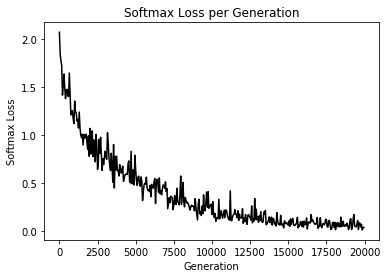

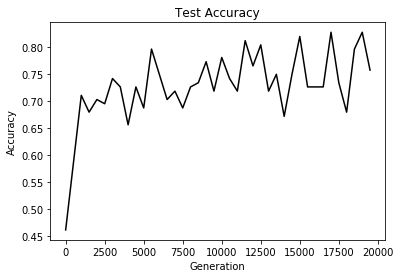

In [18]:
#Finally, here is matplotlib code that will plot the loss and test accuracy over the course of the training
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

# Plot loss over time
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot accuracy over time
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()